# Predicting Conversion Rate

**Description**:    
I am given data about users for a website: 
* Whether they converted or not
* ISP country of origin
* Marketing channel taken to conversion
* Age
* Whether they are repeat users or not
* Number of pages visited during that session

**Goal**:   
Build a model which predicts conversion rate and, based on this model, give recommendations to the product and marketing teams to improve conversion rate and therefore revenue.  

**Results**:   
Here I list the main insights gleaned from my analysis and some associated recommendations.
* Users with an older account are more likely to convert than users with newer accounts.
    * Since they're already in the system, perhaps some targeted emails with offers to bring them back to the site could better capture their conversion potential.
* Chinese users are hard to convert.
    * This could be just due to translation or cultural issues. Either way, considering how many potential users are in China I'd recommend the UX department take a look at ways to improve it.
* German users are relatively easy to convert.
    * Something is going very right with German users and so a little more focus on these users could have a large effect! This could be something for both UX and marketing to look into.
* Young people are much more likely to convert than older people.
    * UX department may want to look into why people 30+ perform so poorly.
* Existing marketing channels do not have a significant effect one way or the other
    * Considering that the site does well with younger users, development of new marketing channels should be done specifically so that they are aimed at reaching younger people.
* If a user has visited many pages but hasn't yet converted, they very likely could have a high purchase intent. Perhaps such users could be sent targeted email offers or reminders.

## Import Libraries and Load Data

First, import all necessary libraries.

In [22]:
# Analysis imports
import numpy as np
import pandas as pd

# Visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# ML imports
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import RandomizedSearchCV
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Miscellaneous imports
import warnings
warnings.filterwarnings('ignore')

Next, I'll load the data.

In [3]:
df = pd.read_csv("conversion_data.csv")
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


## Cleaning the Data and Basic Descriptive Analysis

First, I'll check for null or missing values.

In [4]:
for col in df.columns:
    print "Data types in {} column: {}".format(col, df[col].apply(type).unique())
    print "# of null values in {} column: {}\n".format(col, df[col].isnull().sum())

Data types in country column: [<type 'str'>]
# of null values in country column: 0

Data types in age column: [<type 'int'>]
# of null values in age column: 0

Data types in new_user column: [<type 'int'>]
# of null values in new_user column: 0

Data types in source column: [<type 'str'>]
# of null values in source column: 0

Data types in total_pages_visited column: [<type 'int'>]
# of null values in total_pages_visited column: 0

Data types in converted column: [<type 'int'>]
# of null values in converted column: 0



Doesn't look like any missing or null values are present. Now, I'll check for outliers. 

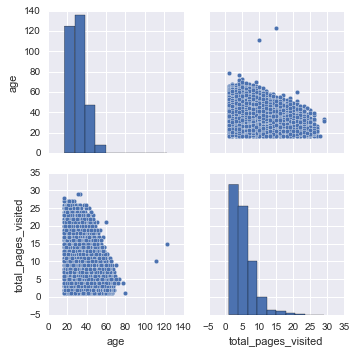

In [5]:
# Look for outliers or major skew
sns.pairplot(df[["age", "total_pages_visited"]])

Looks like a few outliers in age. No fancy stats method is needed here, just remove anything with an age > 80.

In [6]:
# Remove outliers
df = df[df.age < 80]

After cleaning and removing outliers, we can take a look at the overall descriptive statistics before moving on.

In [7]:
# List basic descriptive statistics for all numerical data
df.describe()

,age,new_user,total_pages_visited,converted
count,316198.000000,316198.000000,316198.000000,316198.000000
mean,30.569311,0.685469,4.872918,0.032252
std,8.268958,0.464329,3.341053,0.176669
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,79.000000,1.000000,29.000000,1.000000


I'll also visualize some aspects of the data.    

First, looking at the conversion rate per country we see that China sticks out quite a bit as these users tend to be very hard to convert. One possible reason is that marketing channels may be all english. If the company is interested in increasing Chinese conversion rates, perhaps they could look into translating some of the marketing channels to either Mandarin or Cantonese? Another feature to notice is that German users seem to be the easiest to convert. These points are particular poignant considering the comparison between populations (see 2nd plot below).

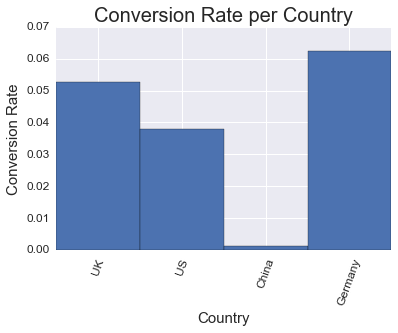

In [8]:
# Display conversion rates per country
country_conversion_rate = []
for country in df.country.unique():
    country_conversion_rate.append((country, 
                                    df[df.country == country].converted.sum() * 1.0 / 
                                    df[df.country == country].shape[0]))

labels, ys = zip(*country_conversion_rate)
xs = np.arange(len(labels)) 
width = 1
plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels, fontsize=12, rotation=70)
plt.yticks([0, .01, .02, .03, .04, .05, .06, .07], fontsize=12)

plt.title("Conversion Rate per Country", fontsize=20)
plt.xlabel("Country", fontsize=15)
plt.ylabel("Conversion Rate", fontsize=15)

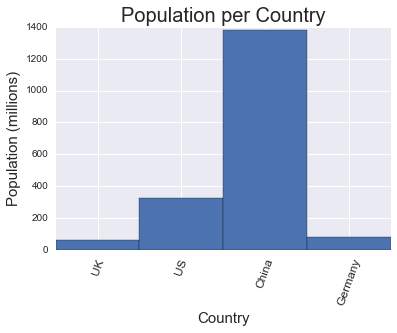

In [9]:
# Compare populations for each country
pops = [("UK",65111143 / 1000000.0), 
        ("US",324118787 / 1000000.0), 
        ("China",1382323332 / 1000000.0), 
        ("Germany",80682351 / 1000000.0)]

labels, ys = zip(*pops)
xs = np.arange(len(labels)) 
width = 1
plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels, fontsize=12, rotation=70)
plt.title("Population per Country", fontsize=20)
plt.xlabel("Country", fontsize=15)
plt.ylabel("Population (millions)", fontsize=15)

Next, I plot the mean conversion rate per total pages visited. This presents a very clear pattern of "the more time spent on the site the more likely a user is to convert".

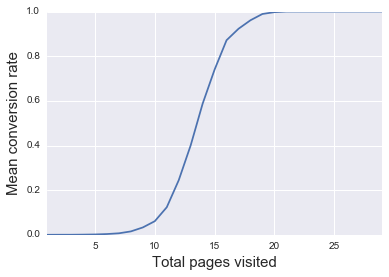

In [10]:
new_df = pd.DataFrame(columns=("total_pages_visited", "mean_conversion_rate"))
ser = df.groupby("total_pages_visited")["converted"].mean()
new_df.total_pages_visited = ser.index
new_df.mean_conversion_rate = ser.values

new_df.plot(x="total_pages_visited", y="mean_conversion_rate", kind="line", legend=None)
plt.xlabel("Total pages visited", fontsize=15)
plt.ylabel("Mean conversion rate", fontsize=15)

## Feature Engineering   

Here, I one-hot-encode the country and source categorial features and use standard normal scaling for the age and total_pages_visited features.

In [11]:
# Create dummy variables for country values
country_dummies = pd.get_dummies(df.country, prefix='country')
df = pd.concat([df, country_dummies], axis=1)

# Create dummy variables for source values
source_dummies = pd.get_dummies(df.source, prefix='source')
df = pd.concat([df, source_dummies], axis=1)

# Normally scale age and total_pages_visited features
feature_list = ["age", "total_pages_visited"]
feature_dict = {}
for feature in feature_list:
    feature_dict[feature + "_mean"] = df[feature].mean()
    feature_dict[feature + "_std"] = df[feature].std()
    df[feature] = (df[feature] - df[feature].mean()) * 1.0 / df[feature].std()

# Drop spurious columns
df.drop(["country", "source"], axis=1, inplace=1)

# Organize columns
df = df[["country_UK", 
            "country_US", 
            "country_Germany", 
            "country_China", 
            "source_Ads", 
            "source_Direct", 
            "source_Seo", 
            "age", 
            "new_user", 
            "total_pages_visited", 
            "converted"]]
df.head()

,country_UK,country_US,country_Germany,country_China,source_Ads,source_Direct,source_Seo,age,new_user,total_pages_visited,converted
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.673520,1,-1.159191,0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.915389,1,0.038036,0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.310718,1,-0.261270,0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.019559,1,0.038036,0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.068849,1,0.337343,0


## Machine Learning   

Here, I split the data into 3 parts for training, hyperparameter tuning, and validation. I chose to use a random forest classification algorithm as it tends to require very little time to optimize, has lots of complexity to handle difficult datasets, and is also fairly robust against overfitting due to its nature of taking a majority vote of randomly generated weak learners. With more time, I would also explore other models, e.g., logistic regression. To account for the class imbalance in the data, I reweight the classes using the class_weight flag passed to the random forest classifier at initialization.

In [12]:
X = df[["country_UK", 
            "country_US", 
            "country_Germany", 
            "country_China", 
            "source_Ads", 
            "source_Direct", 
            "source_Seo", 
            "age", 
            "new_user", 
            "total_pages_visited"]]
Y = df["converted"]

# Split data
X_dev, X_eval, Y_dev, Y_eval = train_test_split(X, Y, train_size=.7, random_state=23)

# Initialize a random forest classifier
rf = RandomForestClassifier(class_weight="balanced")

# Define a parameter grid to search over
param_dist = {"n_estimators": range(50, 250, 50),
              "max_depth": range(3, 7, 2), 
              'criterion': ['gini', 'entropy']}

# Setup 5-fold stratified cross validation
cross_validation = StratifiedKFold(Y_dev, n_folds=5)

# Randomly sample 10 hyperparameter configurations from the grid above and perform 5-fold cross validation for each
n_iter_search = 10
clf = RandomizedSearchCV(rf, 
                         param_distributions=param_dist, 
                         n_iter=n_iter_search, 
                         cv=cross_validation, 
                         n_jobs=10, 
                         verbose=10)
_ = clf.fit(X_dev, Y_dev)

rf_best = clf.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=150, criterion=gini, max_depth=5 ...................
[CV] n_estimators=150, criterion=gini, max_depth=5 ...................
[CV] n_estimators=150, criterion=gini, max_depth=5 ...................
[CV] n_estimators=150, criterion=gini, max_depth=5 ...................
[CV] n_estimators=150, criterion=gini, max_depth=5 ...................
[CV] n_estimators=100, criterion=entropy, max_depth=3 ................
[CV] n_estimators=100, criterion=entropy, max_depth=3 ................
[CV] n_estimators=100, criterion=entropy, max_depth=3 ................
[CV] n_estimators=100, criterion=entropy, max_depth=3 ................
[CV] n_estimators=100, criterion=entropy, max_depth=3 ................
[CV]  n_estimators=100, criterion=entropy, max_depth=3, score=0.942125 -  24.5s
[CV] n_estimators=150, criterion=entropy, max_depth=5 ................
[CV]  n_estimators=100, criterion=entropy, max_depth=3, score=0.947185 -  24.5

[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   25.8s


[CV]  n_estimators=150, criterion=gini, max_depth=5, score=0.937833 -  47.8s
[CV] n_estimators=100, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=150, criterion=gini, max_depth=5, score=0.938262 -  48.0s
[CV] n_estimators=100, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=150, criterion=gini, max_depth=5, score=0.938127 -  48.0s
[CV] n_estimators=100, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=150, criterion=gini, max_depth=5, score=0.941627 -  48.3s
[CV]  n_estimators=150, criterion=gini, max_depth=5, score=0.939278 -  48.2s
[CV] n_estimators=100, criterion=gini, max_depth=3 ...................
[CV] n_estimators=100, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=100, criterion=gini, max_depth=3, score=0.942374 -  23.2s
[CV] n_estimators=50, criterion=gini, max_depth=3 ....................
[CV]  n_estimators=100, criterion=gini, max_depth=3, score=0.943616 -  23.3s
[CV] n_estimators=50, criterion=gin

[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  1.2min


[CV] n_estimators=50, criterion=gini, max_depth=3 ....................
[CV]  n_estimators=150, criterion=entropy, max_depth=5, score=0.942713 -  46.8s
[CV] n_estimators=50, criterion=gini, max_depth=3 ....................
[CV]  n_estimators=100, criterion=gini, max_depth=3, score=0.942960 -  23.3s
[CV] n_estimators=50, criterion=gini, max_depth=3 ....................
[CV]  n_estimators=100, criterion=gini, max_depth=3, score=0.943186 -  23.4s
[CV] n_estimators=100, criterion=entropy, max_depth=5 ................
[CV]  n_estimators=150, criterion=entropy, max_depth=5, score=0.942916 -  47.1s
[CV] n_estimators=100, criterion=entropy, max_depth=5 ................
[CV]  n_estimators=150, criterion=entropy, max_depth=5, score=0.944880 -  47.1s
[CV] n_estimators=100, criterion=entropy, max_depth=5 ................
[CV]  n_estimators=150, criterion=entropy, max_depth=5, score=0.943705 -  47.0s
[CV] n_estimators=100, criterion=entropy, max_depth=5 ................
[CV]  n_estimators=150, crite

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  1.4min


[CV]  n_estimators=50, criterion=gini, max_depth=3, score=0.938533 -  13.0s
[CV] n_estimators=100, criterion=gini, max_depth=5 ...................
[CV]  n_estimators=50, criterion=gini, max_depth=3, score=0.944972 -  13.0s
[CV]  n_estimators=50, criterion=gini, max_depth=3, score=0.945896 -  12.9s
[CV] n_estimators=100, criterion=gini, max_depth=5 ...................
[CV] n_estimators=100, criterion=gini, max_depth=5 ...................
[CV]  n_estimators=50, criterion=gini, max_depth=3, score=0.945038 -  12.8s
[CV] n_estimators=100, criterion=gini, max_depth=5 ...................
[CV]  n_estimators=100, criterion=entropy, max_depth=5, score=0.943232 -  32.6s
[CV] n_estimators=150, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=100, criterion=entropy, max_depth=5, score=0.943187 -  32.5s
[CV] n_estimators=150, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=100, criterion=entropy, max_depth=5, score=0.943322 -  32.5s
[CV] n_estimators=150, criteri

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.8min


[CV]  n_estimators=100, criterion=gini, max_depth=5, score=0.938082 -  32.0s
[CV] n_estimators=200, criterion=entropy, max_depth=5 ................
[CV]  n_estimators=100, criterion=gini, max_depth=5, score=0.940250 -  32.1s
[CV] n_estimators=200, criterion=entropy, max_depth=5 ................
[CV]  n_estimators=100, criterion=gini, max_depth=5, score=0.938125 -  32.1s
[CV] n_estimators=200, criterion=entropy, max_depth=5 ................
[CV]  n_estimators=100, criterion=gini, max_depth=5, score=0.939776 -  32.4s
[CV] n_estimators=200, criterion=entropy, max_depth=5 ................
[CV]  n_estimators=100, criterion=gini, max_depth=5, score=0.939933 -  32.3s
[CV] n_estimators=200, criterion=entropy, max_depth=5 ................
[CV]  n_estimators=150, criterion=gini, max_depth=3, score=0.942577 -  34.0s
[CV] n_estimators=150, criterion=entropy, max_depth=3 ................
[CV]  n_estimators=150, criterion=gini, max_depth=3, score=0.943910 -  34.0s
[CV] n_estimators=150, criterion=en

[Parallel(n_jobs=10)]: Done  37 out of  50 | elapsed:  2.3min remaining:   48.9s


[CV] n_estimators=150, criterion=entropy, max_depth=3 ................
[CV]  n_estimators=150, criterion=gini, max_depth=3, score=0.942237 -  34.2s
[CV] n_estimators=150, criterion=entropy, max_depth=3 ................
[CV]  n_estimators=150, criterion=gini, max_depth=3, score=0.942779 -  34.1s
[CV] n_estimators=150, criterion=entropy, max_depth=3 ................
[CV]  n_estimators=150, criterion=entropy, max_depth=3, score=0.941651 -  35.3s
[CV]  n_estimators=150, criterion=entropy, max_depth=3, score=0.942645 -  35.3s
[CV]  n_estimators=150, criterion=entropy, max_depth=3, score=0.944972 -  35.2s


[Parallel(n_jobs=10)]: Done  43 out of  50 | elapsed:  2.9min remaining:   28.4s


[CV]  n_estimators=150, criterion=entropy, max_depth=3, score=0.937109 -  35.1s
[CV]  n_estimators=150, criterion=entropy, max_depth=3, score=0.945264 -  35.2s
[CV]  n_estimators=200, criterion=entropy, max_depth=5, score=0.943707 - 1.0min
[CV]  n_estimators=200, criterion=entropy, max_depth=5, score=0.943774 - 1.0min
[CV]  n_estimators=200, criterion=entropy, max_depth=5, score=0.944497 -  59.8s
[CV]  n_estimators=200, criterion=entropy, max_depth=5, score=0.944270 -  59.7s
[CV]  n_estimators=200, criterion=entropy, max_depth=5, score=0.944089 -  59.6s


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  3.0min finished


Here, I validate the data by calculating the area under the curve in ROC space using only the validation dataset set aside earlier. Moreover, I also display a full classification report with precision, recall, and F-1 score.

Note that the precision for conversion predictions is quite low compared to that for unconverted. This major imbalance makes me think that perhaps the class reweighting implemented at initialization of the random forest classifier didn't work so well.

Classification report for Random Forest
             precision    recall  f1-score   support

unconverted       1.00      0.95      0.97     91702
  converted       0.37      0.92      0.53      3158

avg / total       0.98      0.94      0.96     94860

Area under ROC curve: 0.934


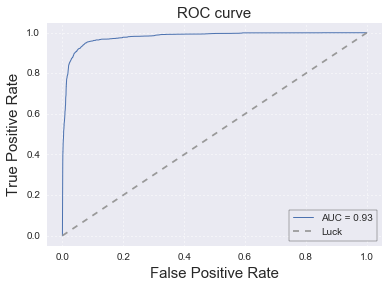

In [13]:
# Collect RF predictions
rf_Ypredicted = rf_best.predict(X_eval)
rf_roc_auc = roc_auc_score(Y_eval, rf_Ypredicted)

print "Classification report for Random Forest"
print classification_report(Y_eval, 
                            rf_Ypredicted,
                            target_names=["unconverted", "converted"])
print "Area under ROC curve: {:0.3f}".format(rf_roc_auc)


# Compute ROC curve and area under the curve for RF
rf_probs = rf_best.predict_proba(X_eval)[:, 1]
rf_fpr, rf_tpr, thresholds = roc_curve(Y_eval, rf_probs)

plt.plot(rf_fpr, rf_tpr, lw=1, label='AUC = %0.2f'%(rf_roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC curve', fontsize=15)
plt.legend(loc="best", frameon = True).get_frame().set_edgecolor('black')
plt.grid(True, linestyle = 'dotted')
plt.show()

Here, I repeat the ML pipeline but with the addition of performing a random upsampling of the data in an effort to address the rather low precision associated with predicting conversions.

In [14]:
# Import module to help with oversampling
from imblearn.over_sampling import RandomOverSampler

feature_list = X.columns

# Apply the random over-sampling
ros = RandomOverSampler()
X, Y = ros.fit_sample(X, Y)

# Restore resampled data to dataframe format
X = pd.DataFrame(X, index=range( X.shape[0] ), columns=feature_list)
Y = pd.Series(Y)

# Split data
X_dev, X_eval, Y_dev, Y_eval = train_test_split(X, Y, train_size=.7, random_state=23)

# Initialize a random forest classifier
rf = RandomForestClassifier()

# Define a parameter grid to search over
param_dist = {"n_estimators": range(50, 250, 50),
              "max_depth": range(3, 7, 2), 
              'criterion': ['gini', 'entropy']}

# Setup 5-fold stratified cross validation
cross_validation = StratifiedKFold(Y_dev, n_folds=5)

# Randomly sample 10 hyperparameter configurations from the grid above and perform 5-fold cross validation for each
n_iter_search = 10
clf = RandomizedSearchCV(rf, 
                         param_distributions=param_dist, 
                         n_iter=n_iter_search, 
                         cv=cross_validation, 
                         n_jobs=10, 
                         verbose=10)
_ = clf.fit(X_dev, Y_dev)

rf_best = clf.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=50, criterion=entropy, max_depth=5 .................
[CV] n_estimators=50, criterion=entropy, max_depth=5 .................
[CV] n_estimators=50, criterion=entropy, max_depth=5 .................
[CV] n_estimators=50, criterion=entropy, max_depth=5 .................
[CV] n_estimators=50, criterion=entropy, max_depth=5 .................
[CV] n_estimators=150, criterion=gini, max_depth=5 ...................
[CV] n_estimators=150, criterion=gini, max_depth=5 ...................
[CV] n_estimators=150, criterion=gini, max_depth=5 ...................
[CV] n_estimators=150, criterion=gini, max_depth=5 ...................
[CV] n_estimators=150, criterion=gini, max_depth=5 ...................
[CV]  n_estimators=50, criterion=entropy, max_depth=5, score=0.935049 -  50.0s
[CV] n_estimators=150, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=50, criterion=entropy, max_depth=5, score=0.937302 -  50.2s


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   51.5s


[CV]  n_estimators=150, criterion=gini, max_depth=5, score=0.939496 - 2.6min
[CV] n_estimators=200, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=150, criterion=gini, max_depth=5, score=0.939602 - 2.6min
[CV] n_estimators=200, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=150, criterion=gini, max_depth=5, score=0.939157 - 2.6min
[CV] n_estimators=200, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=150, criterion=gini, max_depth=3, score=0.935224 - 1.8min
[CV]  n_estimators=150, criterion=gini, max_depth=5, score=0.939286 - 2.6min
[CV] n_estimators=200, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=150, criterion=gini, max_depth=3, score=0.936742 - 1.8min
[CV]  n_estimators=150, criterion=gini, max_depth=3, score=0.933987 - 1.8min
[CV] n_estimators=200, criterion=gini, max_depth=3 ...................


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  2.6min


[CV] n_estimators=100, criterion=entropy, max_depth=3 ................
[CV]  n_estimators=150, criterion=gini, max_depth=3, score=0.936228 - 1.8min
[CV]  n_estimators=150, criterion=gini, max_depth=5, score=0.939904 - 2.6min
[CV] n_estimators=100, criterion=entropy, max_depth=3 ................
[CV] n_estimators=100, criterion=entropy, max_depth=3 ................
[CV]  n_estimators=150, criterion=gini, max_depth=3, score=0.936239 - 1.8min
[CV] n_estimators=100, criterion=entropy, max_depth=3 ................
[CV] n_estimators=100, criterion=entropy, max_depth=3 ................
[CV]  n_estimators=100, criterion=entropy, max_depth=3, score=0.935283 - 1.1min
[CV] n_estimators=200, criterion=entropy, max_depth=3 ................
[CV]  n_estimators=100, criterion=entropy, max_depth=3, score=0.932388 - 1.1min
[CV] n_estimators=200, criterion=entropy, max_depth=3 ................
[CV]  n_estimators=100, criterion=entropy, max_depth=3, score=0.932376 - 1.1min
[CV] n_estimators=200, criterion

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  4.8min


[CV]  n_estimators=200, criterion=gini, max_depth=3, score=0.934267 - 2.2min
[CV] n_estimators=100, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=200, criterion=gini, max_depth=3, score=0.932061 - 2.2min
[CV] n_estimators=100, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=200, criterion=gini, max_depth=3, score=0.932283 - 2.2min
[CV] n_estimators=100, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=200, criterion=gini, max_depth=3, score=0.934278 - 2.2min
[CV] n_estimators=100, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=100, criterion=gini, max_depth=3, score=0.936707 - 1.1min
[CV] n_estimators=100, criterion=entropy, max_depth=5 ................
[CV]  n_estimators=200, criterion=entropy, max_depth=3, score=0.935190 - 2.1min
[CV] n_estimators=100, criterion=entropy, max_depth=5 ................
[CV]  n_estimators=100, criterion=gini, max_depth=3, score=0.934711 - 1.1min
[CV]  n_estimators=100, criterio

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  5.9min


[CV] n_estimators=100, criterion=gini, max_depth=5 ...................
[CV] n_estimators=100, criterion=gini, max_depth=5 ...................
[CV]  n_estimators=200, criterion=entropy, max_depth=3, score=0.932680 - 2.1min
[CV] n_estimators=100, criterion=gini, max_depth=5 ...................
[CV]  n_estimators=200, criterion=entropy, max_depth=3, score=0.934209 - 2.1min
[CV] n_estimators=100, criterion=gini, max_depth=5 ...................
[CV]  n_estimators=200, criterion=entropy, max_depth=3, score=0.934360 - 2.1min
[CV] n_estimators=100, criterion=gini, max_depth=5 ...................
[CV]  n_estimators=100, criterion=entropy, max_depth=5, score=0.935633 - 1.7min
[CV] n_estimators=200, criterion=gini, max_depth=5 ...................
[CV]  n_estimators=100, criterion=entropy, max_depth=5, score=0.935048 - 1.7min
[CV] n_estimators=200, criterion=gini, max_depth=5 ...................
[CV]  n_estimators=100, criterion=entropy, max_depth=5, score=0.934711 - 1.7min


[Parallel(n_jobs=10)]: Done  37 out of  50 | elapsed:  7.6min remaining:  2.7min


[CV] n_estimators=200, criterion=gini, max_depth=5 ...................
[CV]  n_estimators=100, criterion=gini, max_depth=5, score=0.939613 - 1.7min
[CV] n_estimators=200, criterion=gini, max_depth=5 ...................
[CV]  n_estimators=100, criterion=entropy, max_depth=5, score=0.935049 - 1.7min
[CV] n_estimators=200, criterion=gini, max_depth=5 ...................
[CV]  n_estimators=100, criterion=entropy, max_depth=5, score=0.934746 - 1.7min
[CV]  n_estimators=100, criterion=gini, max_depth=5, score=0.938562 - 1.7min
[CV]  n_estimators=100, criterion=gini, max_depth=5, score=0.938469 - 1.7min


[Parallel(n_jobs=10)]: Done  43 out of  50 | elapsed:  7.6min remaining:  1.2min


[CV]  n_estimators=100, criterion=gini, max_depth=5, score=0.938492 - 1.7min
[CV]  n_estimators=100, criterion=gini, max_depth=5, score=0.939927 - 1.7min
[CV]  n_estimators=200, criterion=gini, max_depth=5, score=0.939485 - 1.6min
[CV]  n_estimators=200, criterion=gini, max_depth=5, score=0.938550 - 1.6min
[CV]  n_estimators=200, criterion=gini, max_depth=5, score=0.938819 - 1.6min
[CV]  n_estimators=200, criterion=gini, max_depth=5, score=0.938749 - 1.6min
[CV]  n_estimators=200, criterion=gini, max_depth=5, score=0.938771 - 1.6min


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  9.2min finished


I will now repeat the validation procedure to check whether the resampling helped at all.

Classification report for Random Forest
             precision    recall  f1-score   support

unconverted       0.94      0.94      0.94     91594
  converted       0.94      0.94      0.94     92006

avg / total       0.94      0.94      0.94    183600

Area under ROC curve: 0.939


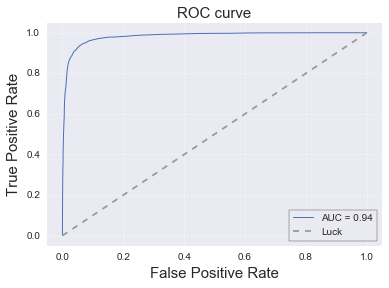

In [15]:
# Collect RF predictions
rf_Ypredicted = rf_best.predict(X_eval)
rf_roc_auc = roc_auc_score(Y_eval, rf_Ypredicted)

print "Classification report for Random Forest"
print classification_report(Y_eval, 
                            rf_Ypredicted,
                            target_names=["unconverted", "converted"])
print "Area under ROC curve: {:0.3f}".format(rf_roc_auc)


# Compute ROC curve and area under the curve for RF
rf_probs = rf_best.predict_proba(X_eval)[:, 1]
rf_fpr, rf_tpr, thresholds = roc_curve(Y_eval, rf_probs)

plt.plot(rf_fpr, rf_tpr, lw=1, label='AUC = %0.2f'%(rf_roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC curve', fontsize=15)
plt.legend(loc="best", frameon = True).get_frame().set_edgecolor('black')
plt.grid(True, linestyle = 'dotted')
plt.show()

This definitely seemed to help. It's a little disconcerting that both precision and recall for all predictions are identical and, given more time, I would look into this but for now, I will move on.

I now show the most important features based on the optimized random forest model.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

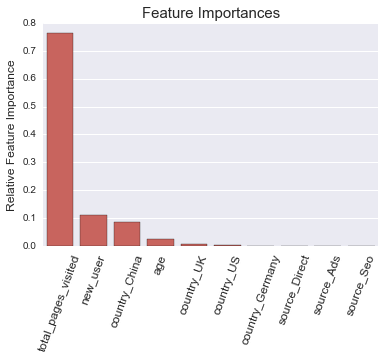

In [16]:
# For random forest, look at most important features
feat_labels = df.columns
importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]

sns.barplot(x=feat_labels[indices], y=importances[indices], color=sns.xkcd_rgb["pale red"])
plt.title('Feature Importances', fontsize=15)
plt.ylabel('Relative Feature Importance', fontsize=12)
plt.xticks(fontsize=12, rotation=70)

The total pages visited feature is by far the most important for the classifier. However, it is also the least interesting because customers who already know they're making a purchase visit more pages by default, simply because converting requires you to visit a number of pages. This information won't be of much help to the product and marketing teams. The next step then is to remove this feature from the model and retrain the model, hopefully identifying more interesting trends.

In [17]:
# Filter out total_pages_visited feature
feature_list = [feature for feature in X.columns if feature != "total_pages_visited"]
X = X[feature_list]

# Split data
X_dev, X_eval, Y_dev, Y_eval = train_test_split(X, Y, train_size=.7, random_state=23)

# Initialize a random forest classifier
rf = RandomForestClassifier()

# Define a parameter grid to search over
param_dist = {"n_estimators": range(50, 250, 50),
              "max_depth": range(3, 7, 2), 
              'criterion': ['gini', 'entropy']}

# Setup 5-fold stratified cross validation
cross_validation = StratifiedKFold(Y_dev, n_folds=5)

# Randomly sample 10 hyperparameter configurations from the grid above and perform 5-fold cross validation for each
n_iter_search = 10
clf = RandomizedSearchCV(rf, 
                         param_distributions=param_dist, 
                         n_iter=n_iter_search, 
                         cv=cross_validation, 
                         n_jobs=10, 
                         verbose=10)
_ = clf.fit(X_dev, Y_dev)

rf_best = clf.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=50, criterion=gini, max_depth=5 ....................
[CV] n_estimators=50, criterion=gini, max_depth=5 ....................
[CV] n_estimators=50, criterion=gini, max_depth=5 ....................
[CV] n_estimators=50, criterion=gini, max_depth=5 ....................
[CV] n_estimators=50, criterion=gini, max_depth=5 ....................
[CV] n_estimators=100, criterion=gini, max_depth=5 ...................
[CV] n_estimators=100, criterion=gini, max_depth=5 ...................
[CV] n_estimators=100, criterion=gini, max_depth=5 ...................
[CV] n_estimators=100, criterion=gini, max_depth=5 ...................
[CV] n_estimators=100, criterion=gini, max_depth=5 ...................
[CV]  n_estimators=50, criterion=gini, max_depth=5, score=0.737993 -  42.5s
[CV] n_estimators=200, criterion=gini, max_depth=5 ...................
[CV]  n_estimators=50, criterion=gini, max_depth=5, score=0.737967 -  42.9s
[CV] n

[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   44.2s


[CV]  n_estimators=100, criterion=gini, max_depth=5, score=0.740689 - 1.4min
[CV] n_estimators=50, criterion=entropy, max_depth=3 .................
[CV]  n_estimators=100, criterion=gini, max_depth=5, score=0.739251 - 1.4min
[CV]  n_estimators=100, criterion=gini, max_depth=5, score=0.737722 - 1.4min
[CV] n_estimators=50, criterion=entropy, max_depth=3 .................
[CV] n_estimators=50, criterion=entropy, max_depth=3 .................
[CV]  n_estimators=100, criterion=gini, max_depth=5, score=0.737278 - 1.4min
[CV] n_estimators=50, criterion=entropy, max_depth=3 .................
[CV]  n_estimators=100, criterion=gini, max_depth=5, score=0.737520 - 1.4min
[CV] n_estimators=50, criterion=entropy, max_depth=3 .................
[CV]  n_estimators=50, criterion=entropy, max_depth=3, score=0.738869 -  31.0s
[CV] n_estimators=150, criterion=gini, max_depth=5 ...................
[CV]  n_estimators=50, criterion=entropy, max_depth=3, score=0.736146 -  31.0s
[CV] n_estimators=150, criterio

[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  2.0min


[CV]  n_estimators=50, criterion=entropy, max_depth=3, score=0.735913 -  31.2s
[CV] n_estimators=150, criterion=gini, max_depth=5 ...................
[CV]  n_estimators=50, criterion=entropy, max_depth=3, score=0.735104 -  31.2s
[CV] n_estimators=150, criterion=gini, max_depth=5 ...................
[CV]  n_estimators=200, criterion=gini, max_depth=5, score=0.740374 - 2.9min
[CV] n_estimators=100, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=200, criterion=gini, max_depth=5, score=0.737967 - 2.9min
[CV] n_estimators=100, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=200, criterion=gini, max_depth=5, score=0.737792 - 2.9min
[CV] n_estimators=100, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=200, criterion=gini, max_depth=5, score=0.739029 - 2.9min
[CV] n_estimators=100, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=200, criterion=gini, max_depth=5, score=0.737602 - 2.9min
[CV] n_estimators=100, criterio

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  4.2min


[CV]  n_estimators=150, criterion=gini, max_depth=5, score=0.739029 - 2.2min
[CV] n_estimators=200, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=150, criterion=gini, max_depth=5, score=0.737640 - 2.2min
[CV]  n_estimators=150, criterion=gini, max_depth=5, score=0.737722 - 2.2min
[CV] n_estimators=200, criterion=gini, max_depth=3 ...................
[CV] n_estimators=200, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=150, criterion=gini, max_depth=5, score=0.737520 - 2.2min
[CV] n_estimators=200, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=100, criterion=gini, max_depth=3, score=0.736278 -  57.2s
[CV] n_estimators=200, criterion=entropy, max_depth=3 ................
[CV]  n_estimators=100, criterion=gini, max_depth=3, score=0.733905 -  57.6s
[CV] n_estimators=200, criterion=entropy, max_depth=3 ................
[CV]  n_estimators=100, criterion=gini, max_depth=3, score=0.733065 -  57.2s
[CV] n_estimators=200, criterion=en

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  4.6min


[CV]  n_estimators=200, criterion=gini, max_depth=3, score=0.736278 - 1.9min
[CV] n_estimators=150, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=200, criterion=gini, max_depth=3, score=0.733905 - 1.9min
[CV] n_estimators=150, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=200, criterion=gini, max_depth=3, score=0.733065 - 1.9min
[CV] n_estimators=150, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=200, criterion=gini, max_depth=3, score=0.731533 - 1.9min
[CV] n_estimators=150, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=200, criterion=gini, max_depth=3, score=0.733695 - 1.9min
[CV] n_estimators=150, criterion=gini, max_depth=3 ...................
[CV]  n_estimators=200, criterion=entropy, max_depth=3, score=0.736278 - 1.9min
[CV] n_estimators=100, criterion=entropy, max_depth=3 ................
[CV]  n_estimators=200, criterion=entropy, max_depth=3, score=0.733905 - 1.9min
[CV] n_estimators=100, criter

[Parallel(n_jobs=10)]: Done  37 out of  50 | elapsed:  6.5min remaining:  2.3min


[CV] n_estimators=100, criterion=entropy, max_depth=3 ................
[CV]  n_estimators=200, criterion=entropy, max_depth=3, score=0.733065 - 1.9min
[CV] n_estimators=100, criterion=entropy, max_depth=3 ................
[CV]  n_estimators=200, criterion=entropy, max_depth=3, score=0.731533 - 1.9min
[CV] n_estimators=100, criterion=entropy, max_depth=3 ................
[CV]  n_estimators=100, criterion=entropy, max_depth=3, score=0.736278 -  58.7s
[CV]  n_estimators=150, criterion=gini, max_depth=3, score=0.736278 - 1.4min
[CV]  n_estimators=100, criterion=entropy, max_depth=3, score=0.733905 -  58.1s


[Parallel(n_jobs=10)]: Done  43 out of  50 | elapsed:  7.5min remaining:  1.2min


[CV]  n_estimators=100, criterion=entropy, max_depth=3, score=0.733065 -  58.3s
[CV]  n_estimators=100, criterion=entropy, max_depth=3, score=0.733695 -  58.1s
[CV]  n_estimators=100, criterion=entropy, max_depth=3, score=0.731533 -  57.7s
[CV]  n_estimators=150, criterion=gini, max_depth=3, score=0.733905 - 1.4min
[CV]  n_estimators=150, criterion=gini, max_depth=3, score=0.733695 - 1.4min
[CV]  n_estimators=150, criterion=gini, max_depth=3, score=0.733065 - 1.4min
[CV]  n_estimators=150, criterion=gini, max_depth=3, score=0.731533 - 1.4min


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  7.5min finished


Here I validate this new model in the same way as before.

Classification report for Random Forest
             precision    recall  f1-score   support

unconverted       0.73      0.75      0.74     91594
  converted       0.75      0.73      0.74     92006

avg / total       0.74      0.74      0.74    183600

Area under ROC curve: 0.740


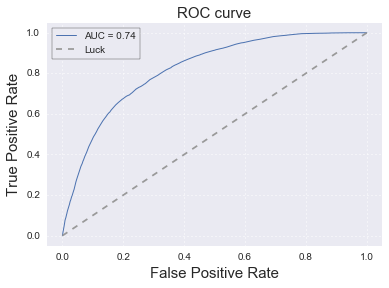

In [18]:
# Collect RF predictions
rf_Ypredicted = rf_best.predict(X_eval)
rf_roc_auc = roc_auc_score(Y_eval, rf_Ypredicted)

print "Classification report for Random Forest"
print classification_report(Y_eval, 
                            rf_Ypredicted,
                            target_names=["unconverted", "converted"])
print "Area under ROC curve: {:0.3f}".format(rf_roc_auc)


# Compute ROC curve and area under the curve for RF
rf_probs = rf_best.predict_proba(X_eval)[:, 1]
rf_fpr, rf_tpr, thresholds = roc_curve(Y_eval, rf_probs)

plt.plot(rf_fpr, rf_tpr, lw=1, label='AUC = %0.2f'%(rf_roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC curve', fontsize=15)
plt.legend(loc="best", frameon = True).get_frame().set_edgecolor('black')
plt.grid(True, linestyle = 'dotted')
plt.show()

The overall AUC score has been reduced, however that is expected after removing the total_pages_visited feature. Now I display the new set of feature importances.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

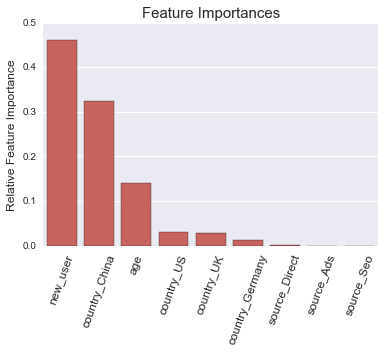

In [19]:
# For random forest, look at most important features
feat_labels = X.columns
importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]

sns.barplot(x=feat_labels[indices], y=importances[indices], color=sns.xkcd_rgb["pale red"])
plt.title('Feature Importances', fontsize=15)
plt.ylabel('Relative Feature Importance', fontsize=12)
plt.xticks(fontsize=12, rotation=70)

Whether or not a user has visited the site before seems to matter quite a bit! After that, whether or not the user is visiting the site from a Chinese ISP or not and user age are also rather important. However, it's also interesting that the marketing channel really doesn't seem to play a role in converting customers much at all.   

As a final takeaway, I would like to include the partial dependence plots for the first 3 features in order of importance. In order to do this, scikit-learn requires the model to be in the gradient boosting family so I'll train and validate a gradient boosting classifier for this purpose.

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize a random forest classifier
gbc = GradientBoostingClassifier()

# Define a parameter grid to search over
param_dist = {"n_estimators": range(50, 250, 50),
              "max_depth": range(3, 7, 2), 
              'learning_rate': [.01, .03, .1, .3]}

# Setup 5-fold stratified cross validation
cross_validation = StratifiedKFold(Y_dev, n_folds=5)

# Randomly sample 10 hyperparameter configurations from the grid above and perform 5-fold cross validation for each
n_iter_search = 10
clf = RandomizedSearchCV(gbc, 
                         param_distributions=param_dist, 
                         n_iter=n_iter_search, 
                         cv=cross_validation, 
                         n_jobs=10, 
                         verbose=10)
_ = clf.fit(X_dev, Y_dev)

gbc_best = clf.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=100, learning_rate=0.01, max_depth=5 ...............
[CV] n_estimators=100, learning_rate=0.01, max_depth=5 ...............
[CV] n_estimators=100, learning_rate=0.01, max_depth=5 ...............
[CV] n_estimators=100, learning_rate=0.01, max_depth=5 ...............
[CV] n_estimators=100, learning_rate=0.01, max_depth=5 ...............
[CV] n_estimators=150, learning_rate=0.03, max_depth=3 ...............
[CV] n_estimators=150, learning_rate=0.03, max_depth=3 ...............
[CV] n_estimators=150, learning_rate=0.03, max_depth=3 ...............
[CV] n_estimators=150, learning_rate=0.03, max_depth=3 ...............
[CV] n_estimators=150, learning_rate=0.03, max_depth=3 ...............
[CV]  n_estimators=150, learning_rate=0.03, max_depth=3, score=0.744949 - 3.9min
[CV] n_estimators=100, learning_rate=0.3, max_depth=3 ................
[CV]  n_estimators=150, learning_rate=0.03, max_depth=3, score=0.742402 - 3.9

[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  3.9min


[CV]  n_estimators=100, learning_rate=0.01, max_depth=5, score=0.744821 - 5.4min
[CV] n_estimators=50, learning_rate=0.3, max_depth=5 .................
[CV]  n_estimators=100, learning_rate=0.01, max_depth=5, score=0.742274 - 5.4min
[CV] n_estimators=50, learning_rate=0.3, max_depth=5 .................
[CV]  n_estimators=100, learning_rate=0.01, max_depth=5, score=0.740920 - 5.4min
[CV] n_estimators=50, learning_rate=0.3, max_depth=5 .................
[CV]  n_estimators=100, learning_rate=0.01, max_depth=5, score=0.742460 - 5.4min
[CV] n_estimators=50, learning_rate=0.3, max_depth=5 .................
[CV]  n_estimators=100, learning_rate=0.01, max_depth=5, score=0.742702 - 5.4min
[CV] n_estimators=50, learning_rate=0.3, max_depth=5 .................
[CV]  n_estimators=100, learning_rate=0.3, max_depth=3, score=0.745930 - 2.3min
[CV] n_estimators=150, learning_rate=0.01, max_depth=3 ...............
[CV]  n_estimators=100, learning_rate=0.3, max_depth=3, score=0.743417 - 2.3min
[CV]  n_e

[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  6.2min


[CV]  n_estimators=100, learning_rate=0.3, max_depth=3, score=0.744045 - 2.3min
[CV] n_estimators=150, learning_rate=0.01, max_depth=3 ...............
[CV]  n_estimators=100, learning_rate=0.3, max_depth=3, score=0.743803 - 2.3min
[CV] n_estimators=150, learning_rate=0.01, max_depth=3 ...............
[CV]  n_estimators=50, learning_rate=0.3, max_depth=5, score=0.743581 - 2.5min
[CV] n_estimators=100, learning_rate=0.3, max_depth=5 ................
[CV]  n_estimators=50, learning_rate=0.3, max_depth=5, score=0.744865 - 2.5min
[CV] n_estimators=100, learning_rate=0.3, max_depth=5 ................
[CV]  n_estimators=50, learning_rate=0.3, max_depth=5, score=0.747599 - 2.6min
[CV] n_estimators=100, learning_rate=0.3, max_depth=5 ................
[CV]  n_estimators=50, learning_rate=0.3, max_depth=5, score=0.745168 - 2.6min
[CV] n_estimators=100, learning_rate=0.3, max_depth=5 ................
[CV]  n_estimators=50, learning_rate=0.3, max_depth=5, score=0.745480 - 2.6min
[CV] n_estimators=1

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 10.0min


[CV]  n_estimators=150, learning_rate=0.01, max_depth=3, score=0.733695 - 3.8min
[CV] n_estimators=150, learning_rate=0.3, max_depth=3 ................
[CV]  n_estimators=150, learning_rate=0.01, max_depth=3, score=0.733905 - 3.8min
[CV] n_estimators=150, learning_rate=0.3, max_depth=3 ................
[CV]  n_estimators=150, learning_rate=0.01, max_depth=3, score=0.733065 - 3.8min
[CV] n_estimators=150, learning_rate=0.3, max_depth=3 ................
[CV]  n_estimators=150, learning_rate=0.01, max_depth=3, score=0.731533 - 3.8min
[CV] n_estimators=150, learning_rate=0.3, max_depth=3 ................
[CV]  n_estimators=100, learning_rate=0.3, max_depth=5, score=0.747902 - 5.0min
[CV] n_estimators=200, learning_rate=0.1, max_depth=3 ................
[CV]  n_estimators=100, learning_rate=0.3, max_depth=5, score=0.745121 - 5.0min
[CV] n_estimators=200, learning_rate=0.1, max_depth=3 ................
[CV]  n_estimators=100, learning_rate=0.3, max_depth=5, score=0.745588 - 5.0min
[CV] n_est

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 13.0min


[CV]  n_estimators=150, learning_rate=0.3, max_depth=3, score=0.743884 - 3.4min
[CV] n_estimators=150, learning_rate=0.01, max_depth=5 ...............
[CV]  n_estimators=150, learning_rate=0.3, max_depth=3, score=0.743289 - 3.4min
[CV] n_estimators=150, learning_rate=0.01, max_depth=5 ...............
[CV]  n_estimators=150, learning_rate=0.3, max_depth=3, score=0.745778 - 3.4min
[CV] n_estimators=150, learning_rate=0.01, max_depth=5 ...............
[CV]  n_estimators=150, learning_rate=0.3, max_depth=3, score=0.743604 - 3.4min
[CV] n_estimators=150, learning_rate=0.01, max_depth=5 ...............
[CV]  n_estimators=150, learning_rate=0.3, max_depth=3, score=0.744640 - 3.4min
[CV] n_estimators=150, learning_rate=0.01, max_depth=5 ...............
[CV]  n_estimators=200, learning_rate=0.1, max_depth=3, score=0.743219 - 4.6min
[CV] n_estimators=200, learning_rate=0.03, max_depth=5 ...............
[CV]  n_estimators=200, learning_rate=0.1, max_depth=3, score=0.745918 - 4.6min
[CV] n_estimat

[Parallel(n_jobs=10)]: Done  37 out of  50 | elapsed: 17.6min remaining:  6.2min


[CV]  n_estimators=200, learning_rate=0.1, max_depth=3, score=0.743709 - 4.6min
[CV] n_estimators=200, learning_rate=0.03, max_depth=5 ...............
[CV]  n_estimators=200, learning_rate=0.1, max_depth=3, score=0.742204 - 4.6min
[CV] n_estimators=200, learning_rate=0.03, max_depth=5 ...............
[CV]  n_estimators=200, learning_rate=0.1, max_depth=3, score=0.743846 - 4.6min
[CV] n_estimators=200, learning_rate=0.03, max_depth=5 ...............
[CV]  n_estimators=150, learning_rate=0.01, max_depth=5, score=0.744914 - 7.8min
[CV]  n_estimators=150, learning_rate=0.01, max_depth=5, score=0.742239 - 7.8min
[CV]  n_estimators=150, learning_rate=0.01, max_depth=5, score=0.740838 - 7.8min
[CV]  n_estimators=150, learning_rate=0.01, max_depth=5, score=0.742460 - 7.9min


[Parallel(n_jobs=10)]: Done  43 out of  50 | elapsed: 21.3min remaining:  3.5min


[CV]  n_estimators=150, learning_rate=0.01, max_depth=5, score=0.742842 - 7.9min
[CV]  n_estimators=200, learning_rate=0.03, max_depth=5, score=0.747108 - 7.3min
[CV]  n_estimators=200, learning_rate=0.03, max_depth=5, score=0.744386 - 7.3min
[CV]  n_estimators=200, learning_rate=0.03, max_depth=5, score=0.743721 - 7.3min
[CV]  n_estimators=200, learning_rate=0.03, max_depth=5, score=0.742904 - 7.3min
[CV]  n_estimators=200, learning_rate=0.03, max_depth=5, score=0.744313 - 7.3min


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed: 24.9min finished


I now display the partial dependence plots for 
* Whether or not the user is new to the site or not
* Whether or not the user has a Chinese ISP or not
* User age

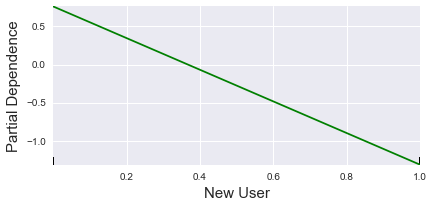

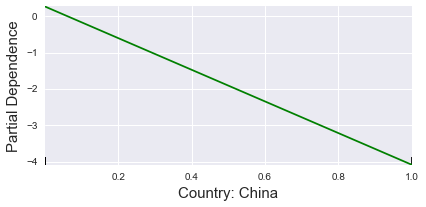

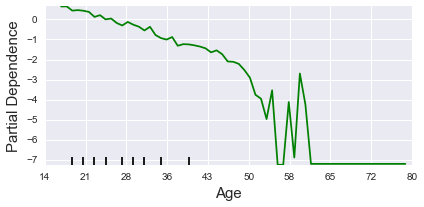

In [23]:
fig, ax = plot_partial_dependence(gbc_best, X, features=[8])
plt.xlabel("New User", fontsize=15)
plt.ylabel("Partial Dependence", fontsize=15)

fig, ax = plot_partial_dependence(gbc_best, X, features=[3])
plt.xlabel("Country: China", fontsize=15)
plt.ylabel("Partial Dependence", fontsize=15)

fig, ax = plot_partial_dependence(gbc_best, X, features=[7])
xvals = np.linspace(-2, 6, 10)
rescaled_list = np.linspace(-2, 6, 10) * feature_dict["age_std"] + feature_dict["age_mean"]
rescaled_labels = ["%d" % label for label in rescaled_list]
plt.xlim(-2, 6)
plt.xticks(xvals, rescaled_labels)
plt.xlabel("Age", fontsize=15)
plt.ylabel("Partial Dependence", fontsize=15)

## Conclusions

Here, I re-iterate my list of gained insights and associated recommendations.
* Users with an older account are more likely to convert than users with newer accounts.
    * Since they're already in the system, perhaps some targeted emails with offers to bring them back to the site could better capture their conversion potential.
* Chinese users are hard to convert.
    * This could be just due to translation or cultural issues. Either way, considering how many potential users are in China I'd recommend the UX department take a look at ways to improve it.
* German users are relatively easy to convert.
    * Something is going very right with German users and so a little more focus on these users could have a large effect! This could be something for both UX and marketing to look into.
* Young people are much more likely to convert than older people.
    * UX department may want to look into why people 30+ perform so poorly.
* Existing marketing channels do not have a significant effect one way or the other
    * Considering that the site does well with younger users, development of new marketing channels should be done specifically so that they are aimed at reaching younger people.
* If a user has visited many pages but hasn't yet converted, they very likely could have a high purchase intent. Perhaps such users could be sent targeted email offers or reminders.